# Air BnB Data Project:
1. Merge, clean and manipulate the data.
2. Identify at least three business questions regarding visitor behavior (one must include age).
3. Use any tools at you disposal to create appropriate visualizations of the data to answer the questions.
4. Articulate conclusions and recommendations based on your analysis.
5. Provide your results in a presentation (PowerPoint or Google slides).  Make sure the presentation is clean and ready to present to Sr. Management.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
airbnb1 = pd.read_excel(r"AirBnBsampleage (1).xlsx", usecols=['Visitor_id', 'Age (years)'])
airbnb2 = pd.read_csv(r"airbnb_session_data (1).txt", delimiter='|')

# Merging Datasets 1 and 2

In [4]:
airbnb1.rename(columns={'Visitor_id': 'id_visitor'}, inplace=True) #make Visitor Id into id_visitor so I can merge with airbnb data 2 on visitor id.
print('Small Data: ', airbnb1.shape, 'Big Data : ', airbnb2.shape)

Small Data:  (630, 2) Big Data :  (7756, 21)


In [5]:
print('Small Data # of IDs: ', airbnb1['id_visitor'].nunique())
print('Big Data # of IDs :', airbnb2['id_visitor'].nunique())

Small Data # of IDs:  630
Big Data # of IDs : 630


--> Great! having the same number of unique ID's means we can do a one to many match merge on ID where the age of that ID (airbnb account) can be filled into the observations of the big data set.

In [6]:
print('Small Data Missing: ', airbnb1.isnull().sum())
print('Big Data Missing:', airbnb2.isnull().sum())

Small Data Missing:  id_visitor     0
Age (years)    0
dtype: int64
Big Data Missing: id_visitor                     0
id_session                     0
dim_session_number             0
dim_user_agent               219
dim_device_app_combo           0
ds                             0
ts_min                         0
ts_max                         0
did_search                     0
sent_message                   0
sent_booking_request           0
next_id_session              630
next_dim_session_number      630
next_dim_user_agent          829
next_dim_device_app_combo    630
next_ds                      630
next_ts_min                  630
next_ts_max                  630
next_did_search              630
next_sent_message            630
next_sent_booking_request    630
dtype: int64


--> The columns for id's in the large dataset that begin with 'next_' are consistently null so instead of imputing a value (i dont have enough data to make a mean or median or the data from the data dictionary) I will drop these values.

--> I need to keep track of null values during the merge to make sure the datasets joined correctly

In [7]:
airbnb2_column_names = airbnb2.columns #list of column names
drop_cols = [] #list i will append unwanted columns

for i in airbnb2_column_names:
    if 'next_' in i:
        drop_cols.append(i)

airbnb2.drop(columns=drop_cols, axis=1, inplace= True)
airbnb2.isnull().sum()

id_visitor                0
id_session                0
dim_session_number        0
dim_user_agent          219
dim_device_app_combo      0
ds                        0
ts_min                    0
ts_max                    0
did_search                0
sent_message              0
sent_booking_request      0
dtype: int64

In [8]:
jointdf = pd.merge(airbnb1, airbnb2, on= 'id_visitor', how = 'right')
jointdf.shape

(7756, 12)

In [9]:
jointdf.drop_duplicates(inplace=True)
jointdf['Booking Requests Per ID'] = jointdf.groupby('id_visitor')['sent_booking_request'].transform('sum')
jointdf.isnull().sum()

id_visitor                   0
Age (years)                  0
id_session                   0
dim_session_number           0
dim_user_agent             219
dim_device_app_combo         0
ds                           0
ts_min                       0
ts_max                       0
did_search                   0
sent_message                 0
sent_booking_request         0
Booking Requests Per ID      0
dtype: int64

# Finding Insights into the Data

**Ideas of helpful insights**
* compare the use of phones, chrome, and other extensions: number of successes (booking) compared to number of fails (visits without booking)
* shorted the dataset to profiles (630) with profile statistics --> predict who is most likely to book (odds, then use a percentile cut off for who we should send discount emails too..example if the odds of a profile booking are between 0.7 and 0.8 then we can give a discount code to push them into purchasing.)
* histogram of profiles: Age Distribution (x) booking total(y)
* create varibale of # of visits before booking (how long before they make a dicision?)
* create variable of # of visits after booking (make a text reminder (option for multiple phones)/email reminder of bnb info to stop web traffic/ease anxiety)
* average session length per age? 
* Average profile website visiting time: more time = bookings?

In [10]:
#Calculating site time per observation
jointdf['ts_min'] = pd.to_datetime(jointdf['ts_min'])
jointdf['ts_max'] = pd.to_datetime(jointdf['ts_max'])
jointdf['Site Visit']= (jointdf['ts_max'] - jointdf['ts_min']).dt.total_seconds()

#Aggragating new profile variables to the joindf
jointdf['Average Site Visit'] = jointdf.groupby('id_visitor')['Site Visit'].transform("mean")

In [11]:
list_device_type = []
listid = []

# Loop through DataFrame to classify devices
for i, row in jointdf.iterrows():
    if 'Desktop' in row['dim_device_app_combo']:
        listid.append(row['id_session'])
        list_device_type.append('Desktop')
    
    elif 'iPhone' in row['dim_device_app_combo']:
        listid.append(row['id_session'])
        list_device_type.append('iPhone')

    # elif 'iPad' in row['dim_device_app_combo']:
    #     listid.append(row['id_session'])
    #     list_device_type.append('iPad')

    elif 'Android' in row['dim_device_app_combo']:
        listid.append(row['id_session'])
        list_device_type.append('Android')
    
    else:
        listid.append(row['id_session'])
        list_device_type.append('Other')

# Create a DataFrame from the lists
tech_type = pd.DataFrame({'id_session': listid, 'Device Type': list_device_type})

# Merge back with jointdf
jointdf = pd.merge(jointdf, tech_type, on='id_session', how='left')

# Check the result
jointdf.head()

,id_visitor,Age (years),id_session,dim_session_number,dim_user_agent,dim_device_app_combo,ds,ts_min,ts_max,did_search,sent_message,sent_booking_request,Booking Requests Per ID,Site Visit,Average Site Visit,Device Type
0,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,a8dfb8ed5aa79e00ff14b2da297c9778,83,Airbnb/6.0 iPhone/8.1.2,iPhone - iOS,2015-02-16,2015-02-16 21:50:41,2015-02-16 22:13:42,0,0,0,15,1381.0,996.741573,iPhone
1,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,950277daef16f86dc2c05d2b212eea81,84,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2015-02-18,2015-02-18 11:57:15,2015-02-18 12:12:48,0,0,0,15,933.0,996.741573,Desktop
2,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,ee4e2f99dd0c0bef2d40e4bdf880c862,85,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2015-02-18,2015-02-18 13:02:13,2015-02-18 13:05:36,0,0,0,15,203.0,996.741573,Desktop
3,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,59fbde7b5d35403116c461fa7fc1ab6e,86,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2015-02-18,2015-02-18 14:18:17,2015-02-18 14:28:47,0,0,0,15,630.0,996.741573,Desktop
4,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,ec8972a3c7256ea4dcba61ee2bd9e3a8,87,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2015-02-19,2015-02-19 12:24:57,2015-02-19 12:24:59,0,0,0,15,2.0,996.741573,Desktop


In [12]:
jointdf3 = jointdf.copy() #joint df for investigation #3
jointdf2 = jointdf.copy() #joint df for investigation #2

# The Invesitgation of Device Types and Booking Habits

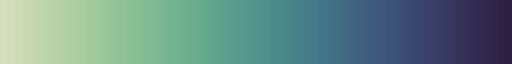

In [13]:
# Extract the hour from the timestamp
jointdf['ts_min'] = jointdf['ts_min'].dt.hour

sns.cubehelix_palette(start=.5, rot=-.75, as_cmap=True)

In [ ]:
# Set global font
plt.rcParams['font.family'] = 'serif'

# Create subplots with 1 row and 2 columns (side by side)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot WEBSITE LOGINS BY HOUR on the first subplot
sns.histplot(
    data=jointdf,
    x='ts_min',
    hue='Device Type',   # Different colors for iPhone/Desktop
    bins=24,
    kde=True,         # Add smooth density line
    multiple="stack", # Stack bars instead of overlapping
    palette="Set2",  # Set color scheme
    ax=axes[0]         # Specify the first subplot (axes[0])
)

# Customize the first subplot
axes[0].set_xlabel("Hour of the Day", fontsize=14, labelpad=15)
axes[0].set_ylabel("Login Count", fontsize=14, labelpad=15)
axes[0].set_title("Website Logins by Hour", fontsize=16, pad=20)

# Define custom x-ticks for every 3 hours
hour_ticks = list(range(0, 24, 3))
hour_labels = [f"{h % 12 if h % 12 else 12} {'AM' if h < 12 else 'PM'}" for h in hour_ticks]
axes[0].set_xticks(hour_ticks)
axes[0].set_xticklabels(hour_labels, fontsize=12)

axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot WEBSITE BOOKINGS BY HOUR on the second subplot
BOOKINGS_df = jointdf[jointdf['sent_booking_request'] == 1].copy()

sns.histplot(
    data=BOOKINGS_df,
    x='ts_min',
    hue='Device Type',   # Different colors for iPhone/Desktop
    bins=24,
    kde=True,         # Add smooth density line
    multiple="stack", # Stack bars instead of overlapping
    palette="Set2",  # Set color scheme
    ax=axes[1]         # Specify the second subplot (axes[1])
)

# Customize the second subplot
axes[1].set_xlabel("Hour of the Day", fontsize=14, labelpad=15)
axes[1].set_ylabel("Login Count", fontsize=14, labelpad=15)
axes[1].set_title("Website Bookings by Hour", fontsize=16, pad=20)

# Define custom x-ticks for every 3 hours
axes[1].set_xticks(hour_ticks)
axes[1].set_xticklabels(hour_labels, fontsize=12)

axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


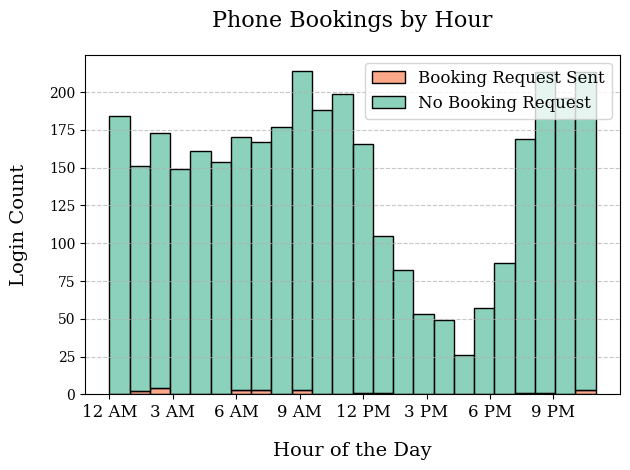

In [ ]:
# Plot WEBSITE BOOKINGS BY HOUR on the second subplot
phone_use_df = jointdf[jointdf['Device Type'] == 'iPhone'].copy()

sns.histplot(
    data=phone_use_df,
    x='ts_min',
    hue='sent_booking_request',   # Different colors for iPhone/Desktop
    bins=24,
    kde=False,         # Add smooth density line
    multiple="stack", # Stack bars instead of overlapping
    palette="Set2",  # Set color scheme
)

# Customize the second subplot
plt.xlabel("Hour of the Day", fontsize=14, labelpad=15)
plt.ylabel("Login Count", fontsize=14, labelpad=15)
plt.title("Phone Bookings by Hour", fontsize=16, pad=20)

# Rename legend labels
new_labels = ['Booking Request Sent', 'No Booking Request']
plt.legend(labels=new_labels, fontsize=12, title=None)

# Define custom x-ticks for every 3 hours
plt.xticks(hour_ticks, hour_labels, fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

# Booking by Searched or Not

In [ ]:
jointdf2['Age (years)'] = jointdf2['Age (years)'].astype(int)
jointdf2['id_visitor'].nunique()

630

In [ ]:
temp4 = jointdf2[jointdf2['sent_booking_request'] == 1]
temp4['id_visitor'].nunique()

50

In [ ]:
profiles_who_booked = (50/630)* 100 #caluclating the 50 who booked out of the 630 who didn't.
print('Only ', round(profiles_who_booked, 2), '% of Profiles have sent booking requests.')

Only  7.94 % of Profiles have sent booking requests.


In [ ]:
jointdf2['did_search'].corr(jointdf2['sent_booking_request'])

np.float64(0.17657254059055705)

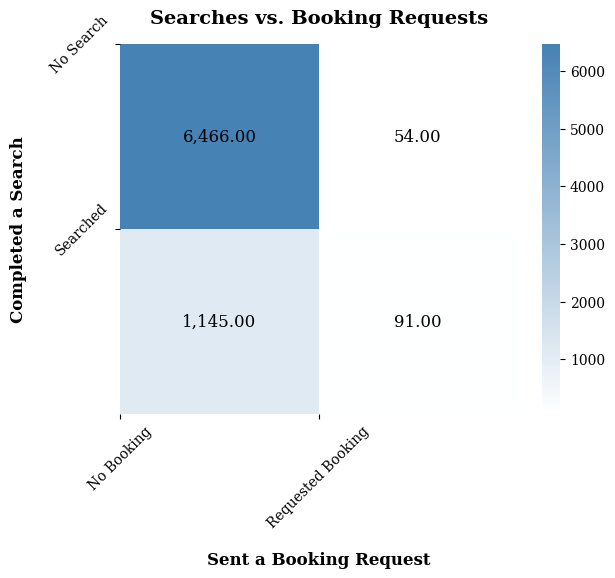

In [ ]:
# Create a contingency table
contingency_table = pd.crosstab(jointdf2['did_search'], jointdf2['sent_booking_request'])

#For coloring:
from matplotlib.colors import LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("blue_white", ["#ffffff", "#4682b4"], N=256)


# Plot heatmap
sns.heatmap(contingency_table, annot=True, cmap=custom_cmap, fmt=",.2f", annot_kws={"size": 12, "color": "Black"})
# Labels
plt.ylabel("Completed a Search", fontsize=12, fontweight="bold", labelpad=15)
plt.xlabel("Sent a Booking Request", fontsize=12, fontweight="bold", labelpad=15)
plt.title("Searches vs. Booking Requests", fontsize=14, fontweight="bold", pad=15)

# Adjust x-ticks (center horizontally)
plt.yticks(ticks=contingency_table.columns, rotation = 45, labels=["No Search", "Searched"])

# Adjust y-ticks (center vertically)
plt.xticks(ticks=contingency_table.index, rotation = 45, labels=["No Booking", "Requested Booking"])

plt.show()

# Age Distribution

In [ ]:
jointdf3.head()


,id_visitor,Age (years),id_session,dim_session_number,dim_user_agent,dim_device_app_combo,ds,ts_min,ts_max,did_search,sent_message,sent_booking_request,Booking Requests Per ID,Site Visit,Average Site Visit,Device Type
0,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,a8dfb8ed5aa79e00ff14b2da297c9778,83,Airbnb/6.0 iPhone/8.1.2,iPhone - iOS,2015-02-16,2015-02-16 21:50:41,2015-02-16 22:13:42,0,0,0,15,1381.0,996.741573,iPhone
1,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,950277daef16f86dc2c05d2b212eea81,84,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2015-02-18,2015-02-18 11:57:15,2015-02-18 12:12:48,0,0,0,15,933.0,996.741573,Desktop
2,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,ee4e2f99dd0c0bef2d40e4bdf880c862,85,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2015-02-18,2015-02-18 13:02:13,2015-02-18 13:05:36,0,0,0,15,203.0,996.741573,Desktop
3,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,59fbde7b5d35403116c461fa7fc1ab6e,86,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2015-02-18,2015-02-18 14:18:17,2015-02-18 14:28:47,0,0,0,15,630.0,996.741573,Desktop
4,ed1329a6-064d-47e9-93bc-93f5a50822df,22.87052,ec8972a3c7256ea4dcba61ee2bd9e3a8,87,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...,Desktop - Chrome,2015-02-19,2015-02-19 12:24:57,2015-02-19 12:24:59,0,0,0,15,2.0,996.741573,Desktop


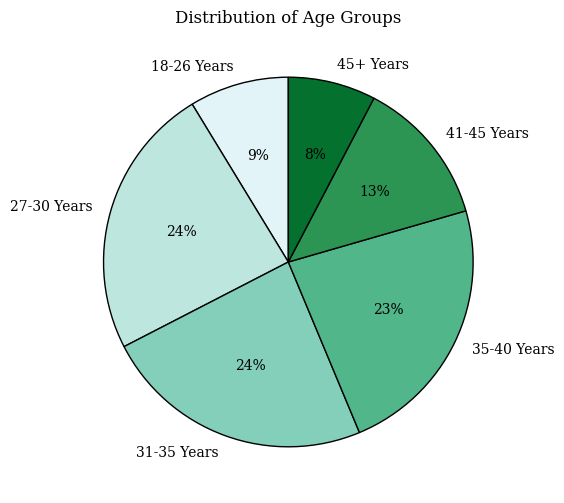

In [ ]:
# Create the age groups with ordered categories
bins = [18, 26, 30, 35, 40, 45, float('inf')]
labels = ['18-26 Years', '27-30 Years', '31-35 Years', '35-40 Years', '41-45 Years', '45+ Years']
jointdf3['Age Group'] = pd.cut(jointdf3['Age (years)'], bins=bins, labels=labels, right=False)

# Make sure the 'Age Group' column is treated as an ordered categorical variable
age_group_order = labels = ['18-26 Years', '27-30 Years', '31-35 Years', '35-40 Years', '41-45 Years', '45+ Years']
jointdf3['Age Group'] = pd.Categorical(jointdf3['Age Group'], categories=age_group_order, ordered=True)

# Count the occurrences of each age group
age_group_counts = jointdf3['Age Group'].value_counts()

# Set Seaborn's "BuGn" color palette
colors = sns.color_palette("BuGn", len(age_group_counts))

# Plot the pie chart with no decimal places and sorted order
plt.figure(figsize=(8, 6))
age_group_counts.sort_index().plot(kind='pie', autopct='%1.0f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'black'})
plt.title('Distribution of Age Groups')
plt.ylabel('')  # Remove the ylabel for a cleaner look
plt.show()